In [57]:
import os, sys, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ffmpeg

from skimage.exposure import rescale_intensity
from skimage.filters import median
import skimage.measure
import skimage.io 
from skimage.segmentation import clear_border
from skimage.morphology import closing, square
from skimage.measure import label, regionprops
from  skimage.color import *
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
from skimage.transform import resize
from skimage.color import rgb2gray
from tqdm import tqdm
from scipy.spatial import distance
import matplotlib.patches as mpatches

In [58]:
def Video_to_Frames(Video_file):
    """
    Video_file: path to video
    it returns a list which contains frames as narray format
    """
    frames = []
    cap = cv2.VideoCapture(Video_file)  
    
    while True:
        ret, frame = cap.read()  
        if not ret:
            break # Reached end of video
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        frames.append(frame)
        
    cap.release()
    return frames

In [59]:
path_video = "robot_parcours_1.avi"
frames = Video_to_Frames(path_video)

------------------------------------------------------------------------------------------------------

In [60]:
def rescale_intensity_levels(img):
    low, high = np.percentile(img, (0, 20))
    return rescale_intensity(img, in_range=(low, high))

In [61]:
def extract_red(im, threshold):
    """
    Outputs only the red object in the image
    """
    copy = im.copy()
    mask = copy[:,:,0] > threshold[0][0]
    for i, (low_thr, high_thr) in enumerate(threshold):
        mask &= (copy[:,:,i] > low_thr)
        mask &= (copy[:,:,i] < high_thr)
    copy[~mask] = (0,0,0)
    return copy

In [62]:
def detect_arrow(src):
    """
    src: source image (H, W, 3)
    returns -> center : (x, y),  bounding box : [minr, minc, maxr, maxc]
                of the red arrow on top of the robot
    """
    #Increase pixels intensity 
    brighter = rescale_intensity_levels(src)
    #Extact red arrow and convert it to gray scale then denormalize it [0, 255]
    red_exctract =  rgb2gray(extract_red(brighter, ((180, 256), (-1,190), (-1,190))))*255
    gray = red_exctract.astype(int)
    #Remove paper and salt
    gray = median(gray)
    gray[gray > 0] = 255
    label_image, b = skimage.measure.label(gray, connectivity=2, return_num=True)
    label_image_overlay = label2rgb(label_image, image=src, bg_label=0)
    centers = []
    for region in skimage.measure.regionprops(label_image):
        # take regions with large enough areas
        if region.area >= 100:
            minr, minc, maxr, maxc = region.bbox
            cx,cy = region.centroid
            cx, cy = int(cx),int(cy)
    center = (cx, cy)
    box = [minr, minc, maxr, maxc]
    assert len(center) == 2, print("No arrow detected")
    return center, box


In [63]:
arrow_center, center_box = detect_arrow(frames[0])

In [64]:
def plot_trajectory2(frames_seen, centers_seen):
    """
    to plot the trajectory of the robot according to the running frame
    """
    fig = Figure(figsize=(5, 4), dpi=180)
    # A canvas must be manually attached to the figure (pyplot would automatically
    # do it).  This is done by instantiating the canvas with the figure as
    # argument.
    canvas = FigureCanvasAgg(fig)

    # Do some plotting.
    ax = fig.add_subplot(111, frameon=False)
    X, Y = list(zip(*centers_seen))
    ax.axis('off')
    # To remove the huge white borders
    ax.margins(0)
    ax.margins(1)
    
    ax.imshow(frames_seen)
    ax.set_axis_off()
    ax.plot(Y, X, "b")
    ax.plot(Y, X, "b.")

    # Option 2: Save the figure to a string.
    canvas.draw()
    s, (width, height) = canvas.print_to_buffer()
    #print(width, height)
    # Option 2a: Convert to a NumPy array.
    output = np.frombuffer(s, np.uint8).reshape((height, width, 4))
    output = output[:,:,:3]
    #print("Output shape: ", output.shape)
    #new_img = resize(output, (480, 720, 3))
    #return new_img.astype(np.uint8)
    start_width = int((720 - 480)/2)
    start_height = int((900 - 720)/2)

    end_width = 720 - start_width
    end_height = 900 - start_height
    resized_img = output[start_width : end_width, start_height:end_height, :]
    
    return resized_img, output

In [65]:
centers, seen_frames = [], []
generating_frames = []

for frame in frames:
	#if frame.max() <= 1:					#Because resize() in plot trajectory, it rescales frames
	# frame = frame * 255
	center, _ = detect_arrow(frame)
	centers.append(center)
	seen_frames.append(frame)
	new_frame, _ = plot_trajectory2(frame, centers)
	generating_frames.append(new_frame)

In [66]:
print("Generated frames: ", len(generating_frames))

Generated frames:  42


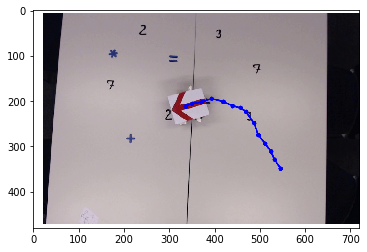

In [67]:
plt.imshow(generating_frames[15])
#resized_img = plot_trajectory2(seen_frames[:15], centers[:15])

------------------------------------------------------------------------------------------------------

In [68]:
def preprocess(image):
    """
    Image: input frame (W, H, 3)
    return: - cleared: clear mask of the input image
            - boxes, areas, centers : features for each object within the image
    """
    output = rescale_intensity_levels(image)
    gray_im = skimage.color.rgb2gray(output)
    gray_filtered = median(gray_im)
    filtered = skimage.filters.gaussian(gray_filtered, sigma = 1)
    #prewitt = skimage.filters.prewitt(filtered)
    #edge = skimage.filters.laplace(gray_filtered) * 255
    thresholded  = gray_im  < skimage.filters.threshold_otsu(filtered)
    
    mask = closing(thresholded , square(2) )
         
    cleared = clear_border(mask)
    plt.imshow(cleared)
    
    labels, count = skimage.measure.label(cleared, connectivity=1, return_num=True)
    
    boxes = []
    areas = []
    centers = []
    for region in regionprops(labels):
        if 400 >= region.bbox_area >= 50:
            areas.append(region.bbox_area)
            cx,cy = region.centroid
            centers.append((int(cx), int(cy)))
            minr, minc, maxr, maxc = region.bbox
            boxes.append([minr-12, minc-12, maxr+12, maxc+12])            
    
    #print("Shapes properties: [minx, miny, maxx, maxy] \n", boxes)
    #print("Count Objects: ", len(boxes))
    return cleared, boxes, areas, centers

In [69]:
def withIn_Box(pixel, box):
    """
    Pixel : in this case is the center of the Box, we could like to check if the pixel belongs to the box
    Box : [minr, minc, maxr, maxc]
    return True/False
    """
    withint = False
    if box[0] < pixel[0] < box[2]:
        if box[1] < pixel[1] < box[3]:
            withint = True
    return withint

In [70]:
def extract_valid_objects(boxes, centers, arrow_center):
    """
    Boxes: input given by preprocessing function, [minr, minc, maxr, maxc]
    centers: input given by preprocessing function, list of 2D tuples
    return valid boxes of objects and their centers
    """
    valid_boxes = boxes.copy()
    valid_centers = centers.copy()
    for i, center in enumerate(centers[:-1]):
        for box in boxes[i+1:]:
            if withIn_Box(center, box):
                [minr, minc, maxr, maxc] = boxes[i]
                new_maxr, new_maxc = boxes[i+1][2], boxes[i+1][3]
                boxes[i] = [minr, minc, new_maxr, new_maxc]
                next_box, next_center = boxes[i+1], centers[i+1]
                valid_boxes.remove(next_box)
                valid_centers.remove(next_center)

    valid_boxes2 = []
    valid_centers2 = []

    for i, box in enumerate(valid_boxes):
        HeightWidthRatio = round((box[3] - box[1]) / (box[2] - box[0]), 2)
        #Calculating the distance to eliminate box 10, 11 (near the arrow)
        dst = distance.euclidean(arrow_center, valid_centers[i])
        if (HeightWidthRatio > 0.5) and (dst > 60):
            valid_boxes2.append(box)
            valid_centers2.append(valid_centers[i])
    return valid_boxes2, valid_centers2

In [71]:
def AllInfoFromFrame0(frame):
    """
    Assembling all the previous function into a main to get all the information we need from frame 0
    return : frame with every object withint a box
    """
    cleared, boxes, areas, centers = preprocess(frame)
    arrow_center, center_box = detect_arrow(frame)
    real_boxes, real_centers = extract_valid_objects(boxes, centers, arrow_center)
    
    fig = Figure(figsize=(5, 4), dpi=180)
    fig.tight_layout(pad=0)
    
    canvas = FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, frameon=False)
    
    ax.axis('off')
    # To remove the huge white borders
    ax.margins(0)
    ax.margins(1)
    
    ax.imshow(frame)
    ax.set_axis_off()
    for i, box in enumerate(real_boxes):
        [minr, minc, maxr, maxc] = box
        rect = mpatches.Rectangle((minc, minr), (maxc - minc), (maxr - minr),
                                      fill=False, edgecolor='white', linewidth= 2)

        ax.add_patch(rect)
    
    canvas.draw()
    s, (width, height) = canvas.print_to_buffer()
    output = np.frombuffer(s, np.uint8).reshape((height, width, 4))
    output = output[:,:,:3]
    
    
    start_width = int((720 - 480)/2)
    start_height = int((900 - 720)/2)

    end_width = 720 - (start_width)
    end_height = 900 - (start_height)

    resized_img = output[start_width : end_width, start_height:end_height, :]
    return resized_img, real_boxes, real_centers

/Users/user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: tight_layout : falling back to Agg renderer
  # This is added back by InteractiveShellApp.init_path()


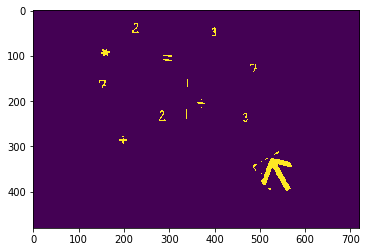

In [72]:
resized_img, real_boxes, real_centers = AllInfoFromFrame0(frames[0])

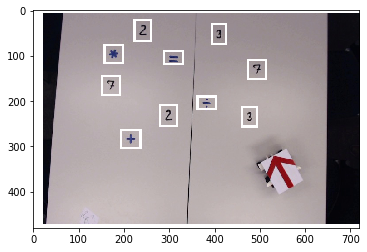

In [73]:
plt.imshow(resized_img)

/Users/user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: tight_layout : falling back to Agg renderer
  # This is added back by InteractiveShellApp.init_path()


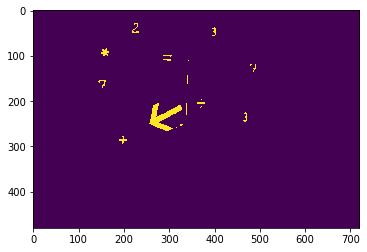

In [76]:
resized_img2, real_boxes2, real_centers2 = AllInfoFromFrame0(frames[17])

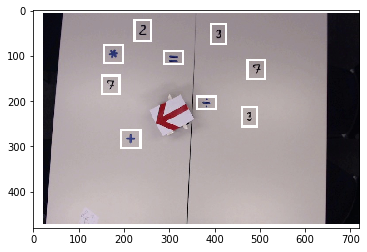

In [77]:
plt.imshow(resized_img2)

--------------------------------------------------------------------------------

In [30]:
def extract_signs(boxes, frame):
    """
    A function to extract sign from frame, in order to classify them
    boxes: [minr, minc, maxr, maxc]
    frame : which we would like to extract signs from in GRAYSCALE FORMAT
        -- Note: This frame should not contain boxes aroud object (CLEAR FRAME)
    return : np array of [len(boxes), 28, 28] 
    """
    objects  = np.zeros((len(boxes), 28, 28))
    for i, box in enumerate(boxes):
        obj = frame[box[0]:box[2], box[1]: box[3]]
        obj = resize(obj, (28, 28))
        objects[i] = obj
    return objects

In [78]:
frame = rgb2gray(frames[0])
objects = extract_signs(real_boxes, frame)

In [83]:
print("\tNumber of Objects detected in frame 0 is: {}".format(len(objects)))

	Number of Objects detected in frame 0 is: 9


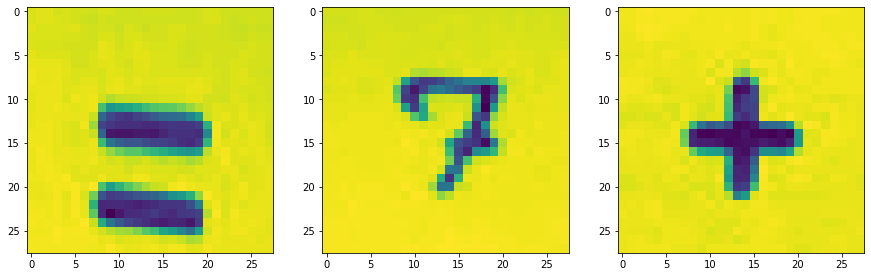

In [82]:
fig, ax = plt.subplots(1, 3, figsize = (15, 12))
ax[0].imshow(objects[3])
ax[1].imshow(objects[5])
ax[2].imshow(objects[8])